In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pm4py
import warnings
# Custom package
from pm_pd_utils import initial_dataframe_analysis

In [2]:
sns.set_theme(style='darkgrid')
warnings.filterwarnings("ignore")

In [4]:
DATA_FILE_PATH = 'data/dispatch_data.csv'
df = pd.read_csv(DATA_FILE_PATH)
df = df.drop(columns=['shiftname.1'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(3)

,case_id,activity,timestamp,resource,crew,shiftname,loadlocationunit,excav,loadlocation,truck,dumplocation,dumplocationunit
0,0,Assign Carga,2024-03-26 07:58:02.200,Darwin Orellana Rojo,G4,240326a,Disparo,PA,F11,CA94,BOT-HUA-3680/B,Botadero
1,0,Arrive Carga,2024-03-26 08:07:39.000,Darwin Orellana Rojo,G4,240326a,Disparo,PA,F11,CA94,BOT-HUA-3680/B,Botadero
2,0,Spotting Carga,2024-03-26 08:07:39.000,Darwin Orellana Rojo,G4,240326a,Disparo,PA,F11,CA94,BOT-HUA-3680/B,Botadero


In [28]:
print('Total cases:      :', df['case_id'].nunique())
print('Dump Location unit:', ', '.join(df['dumplocationunit'].unique().tolist()))
print('Dump Location     :', ', '.join(df['dumplocation'].unique().tolist()))
print('Load Location     :', ', '.join(df['loadlocation'].unique().tolist()))

Total cases:      : 40923
Dump Location unit: Botadero, Chancado, Stock
Dump Location     : BOT-HUA-3680/B, CH-02, BOT-HUA-3650/B, CH-1, STOC-2961-BL, BOT-RAMP-3680, RELL-PRET-F11W, BOT-ENS-2978, STOC-3080-00, RELL-PRET-F7, PLT-GRAVILLA, RELL-SOBRE-F9SE, STOC-GRAVILLA-2, RELL-PRET-F9, RELL-CARP-F9SE, STOC-3005-BOLO, STOC-FIERRO-ESCUELITA, RELL-CARP-F11W, RELL-CARP-F10, BOT-CNEGRO-3080, STOC-2960-BL, RAMPA_F09, BOT-RL-2760, RELL-SOBRE-F11W, RELL-INPI-F12, RELL-PRET-F10N, BOT-HUA-3650, RELL-PRET-F12N, RELL-SOBRE-F10N, STOC-3060-00, STOC-2960-00, STOC-3000-00, RELL-CARP-F12, BOT-RELL-3598-F12, STOC-3005-00, STOC-C.NEGRO-FIERRO, BOT_RELL_HITO, RELL-CARP-F121, BOT-3680-NORTE, BOT-DESC-F12-ESTE, RELL-SOBRE-F12N, BOT-3680-SUR
Load Location     : F11, F9, F12, STOC, F10, P21, S00, M17, M21, M18, M47, CUBICULOS-ENAEX, M7


In [6]:
def ordered_series(df: pd.Series) -> list[str]:
  return df.value_counts().index

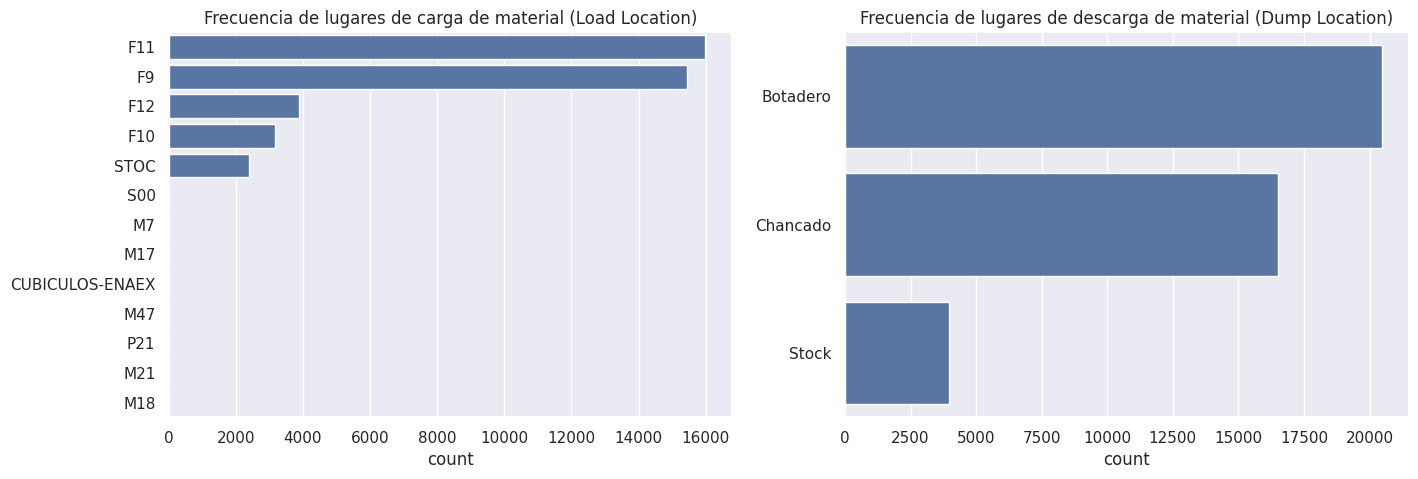

In [36]:
# Plot the frecuencies of load_location_unit and load_location
def plot_frequency_columns(df: pd.DataFrame, rows: list[str]):
  df_not_repeated = df[['case_id', *rows]].groupby('case_id').first()
  _, (ax1, ax2) = plt.subplots(ncols=len(rows), nrows=1, figsize=(8*len(rows), 5))
  sns.countplot(data=df_not_repeated, y='loadlocation', ax=ax1, order=ordered_series(df_not_repeated['loadlocation']))
  sns.countplot(data=df_not_repeated, y='dumplocationunit', ax=ax2, order=ordered_series(df_not_repeated['dumplocationunit']))
  ax1.set_title('Frecuencia de lugares de carga de material (Load Location)')
  ax2.set_title('Frecuencia de lugares de descarga de material (Dump Location)')
  ax1.set(ylabel=None)
  ax2.set(ylabel=None)

plot_frequency_columns(df, ['loadlocation', 'dumplocationunit'])

In [41]:
# Cut the cases where the count is less than this threshold
THRESHOLD = 50 * 8 # Threshold multiply by total activities per event log case
def list_to_keep(df: pd.DataFrame, column: str, threshold: int = THRESHOLD) -> list[str]:
  """
    For a categorical column returns a list of items that are repeated with more or equal than a "THRESHOLD" value
  """
  series_keep = df[column].value_counts() >= threshold
  removed_values = series_keep[df[column].value_counts() < threshold].index
  print(f'The following list of the column {column} where removed')
  for index, removed_value in enumerate(removed_values):
    print(f'{index + 1}) {removed_value}')

  return series_keep[series_keep].index.tolist()

load_location_keep = list_to_keep(df, 'loadlocation')
load_location_unit_keep = list_to_keep(df, 'dumplocationunit')
df_filtered = df[df['loadlocation'].isin(load_location_keep) & df['dumplocationunit'].isin(load_location_unit_keep)]

The following list of the column loadlocation where removed
1) S00
2) M7
3) M17
4) M47
5) CUBICULOS-ENAEX
6) P21
7) M21
8) M18
The following list of the column dumplocationunit where removed


In [42]:
print(f'Filtered from {df.shape[0]:_} rows to {df_filtered.shape[0]:_}. {(df.shape[0] - df_filtered.shape[0]):_} rows filtered')

Filtered from 368_307 rows to 367_911. 396 rows filtered


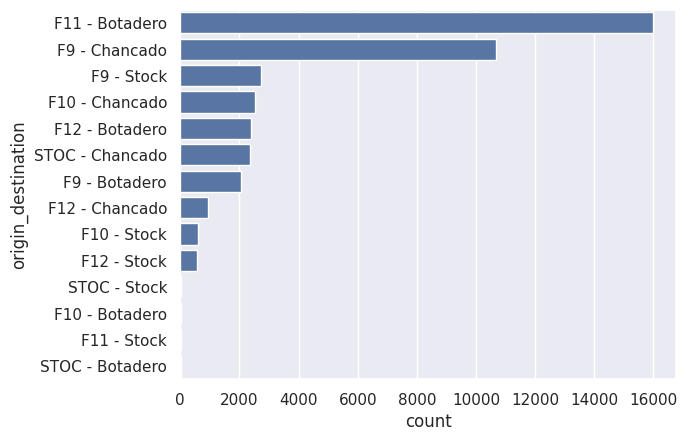

In [61]:
# Create an artificial column that contains both loadlocation and loadlocationunit and count what combination is most repeated
df_filtered_copy = df_filtered.copy()
df_filtered_copy['origin_destination'] = df_filtered_copy['loadlocation'].str.cat(df_filtered_copy['dumplocationunit'], sep=' - ')
df_filtered_copy_not_removed = df_filtered_copy.groupby('case_id').first()
sns.countplot(df_filtered_copy_not_removed['origin_destination'], order=df_filtered_copy_not_removed['origin_destination'].value_counts().index);

In [62]:
origin_destination_to_keep = list_to_keep(df_filtered_copy, 'origin_destination')
df_full_filtered = df_filtered_copy[df_filtered_copy['origin_destination'].isin(origin_destination_to_keep)]

The following list of the column origin_destination where removed
1) STOC - Stock
2) F10 - Botadero
3) F11 - Stock
4) STOC - Botadero


In [63]:
print(f'Filtered from {df_filtered_copy.shape[0]:_} rows to {df_full_filtered.shape[0]:_}. Total of {(df_filtered_copy.shape[0] - df_full_filtered.shape[0]):_} rows filtered')

Filtered from 367_911 rows to 367_002. Total of 909 rows filtered


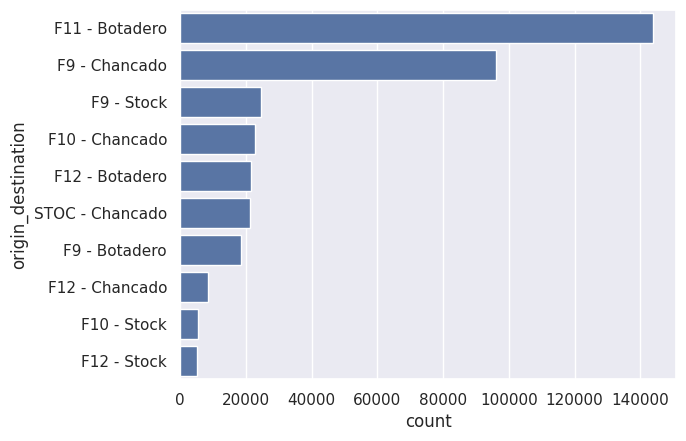

In [57]:
sns.countplot(df_full_filtered['origin_destination'], order=df_full_filtered['origin_destination'].value_counts().index.tolist());

In [64]:
df_to_analyze = df_full_filtered.copy()

In [65]:
df_count_origin_destination = df_to_analyze[['origin_destination', 'case_id']].groupby('case_id').first() \
  .value_counts() \
  .reset_index() \
  .rename(columns={'count': 'frequency'})
df_count_origin_destination

,origin_destination,frequency
0,F11 - Botadero,15973
1,F9 - Chancado,10662
2,F9 - Stock,2729
3,F10 - Chancado,2530
4,F12 - Botadero,2393
5,STOC - Chancado,2352
6,F9 - Botadero,2049
7,F12 - Chancado,928
8,F10 - Stock,613
9,F12 - Stock,549


In [66]:
def plot_dfg_from_df(df: pd.DataFrame, origin_destination_column: str):
  df_filtered = df[df['origin_destination'] == origin_destination_column]
  print(f'The data with origin - destination <{origin_destination_column}> rows: {df_filtered.groupby('case_id').ngroups}')
  event_log_filtered, _, _ = initial_dataframe_analysis(df_filtered, with_dfg=True)
  return df_filtered, event_log_filtered

The data with origin - destination <F12 - Chancado> rows: 928


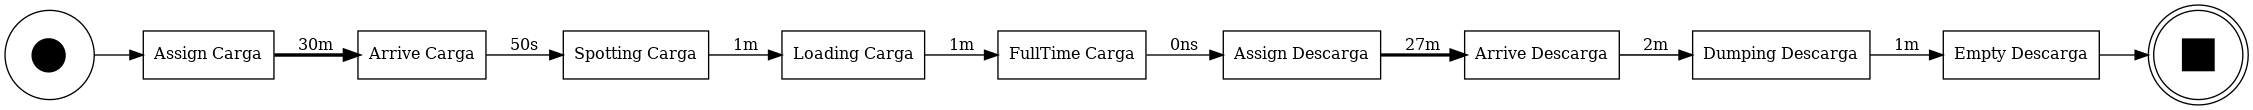

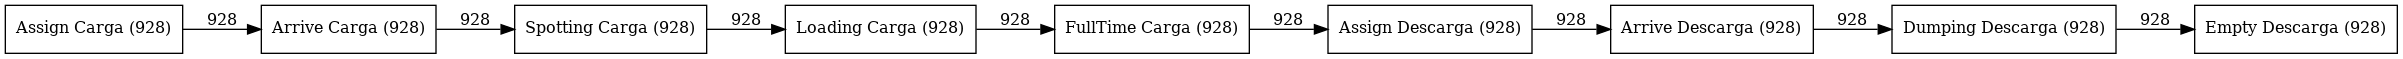

In [68]:
# df_f10_disparo = df_to_analyze[df_to_analyze['origin_destination'] == 'F10 - Disparo']
df_f12_chancado, _ = plot_dfg_from_df(df_to_analyze, 'F12 - Chancado')

In [69]:
def obtain_time_metrics_between_activities(df: pd.DataFrame, activities: list[str]):
  # TODO: raise error if the activities are not in the dataframe
  set_unique_activities = set(df['activity'].unique().tolist())
  if len(set(activities) - set(set_unique_activities)) > 0:
    raise Exception(f'Cannot use this activities: {', '.join([*activities])}')
  df_activities = df[df['activity'].isin(activities)]
  return (df_activities.groupby(by='case_id')['timestamp'].diff().dt.total_seconds() / 60).dropna() \
    .describe() \
    .rename({'25%': 'perc_25', '50%': 'median', '75%': 'perc_75'}) \
    .to_dict()
  
obtain_time_metrics_between_activities(df_f12_chancado, ['Assign Carga', 'Arrive Carga'])

{'count': 928.0,
 'mean': 30.09700790229885,
 'std': 28.32808078209276,
 'min': 0.08,
 'perc_25': 21.83,
 'median': 23.438333333333333,
 'perc_75': 27.013333333333332,
 'max': 432.38}

In [70]:
def df_with_paired_activities_timestamp(df: pd.DataFrame) -> pd.DataFrame:
  """
    Function to pivot data and show times in columns, alternative option to obtain_time_metrics_between_activities
  """
  return pd.pivot(df[df['activity'].isin(['Assign Carga', 'Arrive Carga'])], index='case_id', columns=['activity'], values='timestamp')

In [71]:
from itertools import pairwise
unique_activities = df['activity'].unique().tolist()
PAIRED_ACTIVITIES = [*pairwise(unique_activities)]

In [72]:
def obtain_delta_time_metrics(df: pd.DataFrame, df_name: str) -> list[dict]:
  return [{'origin_destination': df_name,
           'initial_activity': pair_activity[0],
           'final_activity': pair_activity[1],
            **obtain_time_metrics_between_activities(df, pair_activity)} 
         for pair_activity in PAIRED_ACTIVITIES]

In [73]:
list_origin_destinations = df_count_origin_destination['origin_destination'].tolist()
lowerize_name = lambda name: name.replace(' ', '').replace('-','_').lower()
list_segmented_df = [[lowerize_name(origin_destination), df_to_analyze[df_to_analyze['origin_destination'] == origin_destination]] for origin_destination in list_origin_destinations]

df_metrics = [pd.DataFrame(data=obtain_delta_time_metrics(df, df_name)) for df_name, df in list_segmented_df]

In [74]:
summary_per_df = pd.concat(df_metrics).rename(columns={'50%': 'median'}).drop(columns=['std', 'perc_25', 'min', 'perc_75', 'max'])

In [75]:
summary_per_df.groupby(by="origin_destination")['mean'].sum().to_frame().reset_index()

,origin_destination,mean
0,f10_chancado,63.079480
1,f10_stock,65.976221
2,f11_botadero,52.371430
3,f12_botadero,32.110575
4,f12_chancado,64.616333
5,f12_stock,63.175446
6,f9_botadero,39.179000
7,f9_chancado,23.864568
8,f9_stock,36.508814
9,stoc_chancado,32.910265


In [94]:
summary_per_df.to_csv('data/summary_per_df.csv', index=False)

In [76]:
summary_per_df.head()

,origin_destination,initial_activity,final_activity,count,mean,median
0,f11_botadero,Assign Carga,Arrive Carga,15973.0,19.819701,12.180000
1,f11_botadero,Arrive Carga,Spotting Carga,15973.0,1.728487,0.000000
2,f11_botadero,Spotting Carga,Loading Carga,15973.0,1.168984,0.966667
3,f11_botadero,Loading Carga,FullTime Carga,15973.0,2.021698,1.433333
4,f11_botadero,FullTime Carga,Assign Descarga,15973.0,0.000000,0.000000


In [78]:
summary_per_df[summary_per_df['initial_activity'] == 'Assign Carga']

,origin_destination,initial_activity,final_activity,count,mean,median
0,f11_botadero,Assign Carga,Arrive Carga,15973.0,19.819701,12.180000
0,f9_chancado,Assign Carga,Arrive Carga,10662.0,9.884136,3.780000
0,f9_stock,Assign Carga,Arrive Carga,2729.0,15.139430,7.713333
0,f10_chancado,Assign Carga,Arrive Carga,2530.0,28.655507,21.896667
0,f12_botadero,Assign Carga,Arrive Carga,2393.0,14.302656,4.246667
0,stoc_chancado,Assign Carga,Arrive Carga,2352.0,12.342585,6.246667
0,f9_botadero,Assign Carga,Arrive Carga,2049.0,14.408510,5.330000
0,f12_chancado,Assign Carga,Arrive Carga,928.0,30.097008,23.438333
0,f10_stock,Assign Carga,Arrive Carga,613.0,27.584323,21.730000
0,f12_stock,Assign Carga,Arrive Carga,549.0,31.947668,24.046667


In [83]:
def plot_process_time(df: pd.DataFrame, origin_destination: str, period: str = '15T'):
  #!: Validate that the needed columns are in the df dataframe
  unique_origin_destination = df['origin_destination'].unique().tolist()
  if not origin_destination in unique_origin_destination:
    raise Exception(f'The "origin_destination" must be between these values: {unique_origin_destination}')

  available_periods = ['10T', '15T', '20T', '30T', 'H']
  if not period in available_periods:
    raise Exception('Periods must be one of these values: ', available_periods)

  df_copy = df.copy()[df['origin_destination'] == origin_destination]
  df_copy['timediff'] = df_copy[['case_id', 'timestamp']].groupby('case_id')['timestamp'].diff().dt.total_seconds() / 60
  short_df = df_copy[['case_id', 'activity', 'timestamp', 'timediff']]
  between_activities = ['Assign Carga', 'Empty Descarga']
  df_first_act = short_df[short_df['activity'] == 'Assign Carga'].drop(columns=['timediff'])
  df_timediff = short_df.groupby('case_id')['timediff'].sum().reset_index()
  df_merged = df_first_act.merge(df_timediff, on='case_id')
  df_merged['truncated_ts'] = df_merged.drop(columns=['activity'])['timestamp'].dt.floor(period)
  df_merged['format_hour'] = df_merged['truncated_ts'].dt.strftime('%H:%M')
  df_merged['hour_sorted'] = df_merged['truncated_ts'].dt.strftime('%H.%M').astype(float)
  df_merged['hour_sorted'] = df_merged['hour_sorted'].astype(int) + (df_merged['hour_sorted'] % 1) * 10 / 6
  # Obtain unique values for the hour
  unique_ticks = df_merged[['hour_sorted', 'format_hour']].drop_duplicates().sort_values(by='hour_sorted')
  # Start figures
  fig, (ax1, ax2) = plt.subplots(figsize=(15, 11), ncols=1, nrows=2)
  fig.tight_layout(h_pad=5)
  sns.barplot(data=df_merged, x='hour_sorted', y='timediff', ax=ax1)
  ax1.set_title(f'Bar plot with mean in {origin_destination}')
  ax1.set_xticklabels(unique_ticks['format_hour'], rotation=45, fontsize=8)
  ax1.set(xlabel="Hora de día", ylabel="Tiempo de ciclo")
  sns.countplot(data=df_merged, x='hour_sorted', ax=ax2)
  ax2.set_title(f'Frequency of dispatch movements in {origin_destination}')
  ax2.set_xticklabels(unique_ticks['format_hour'], rotation=45, fontsize=8)
  ax2.set(xlabel="Hora del día", ylabel="Frecuencia")


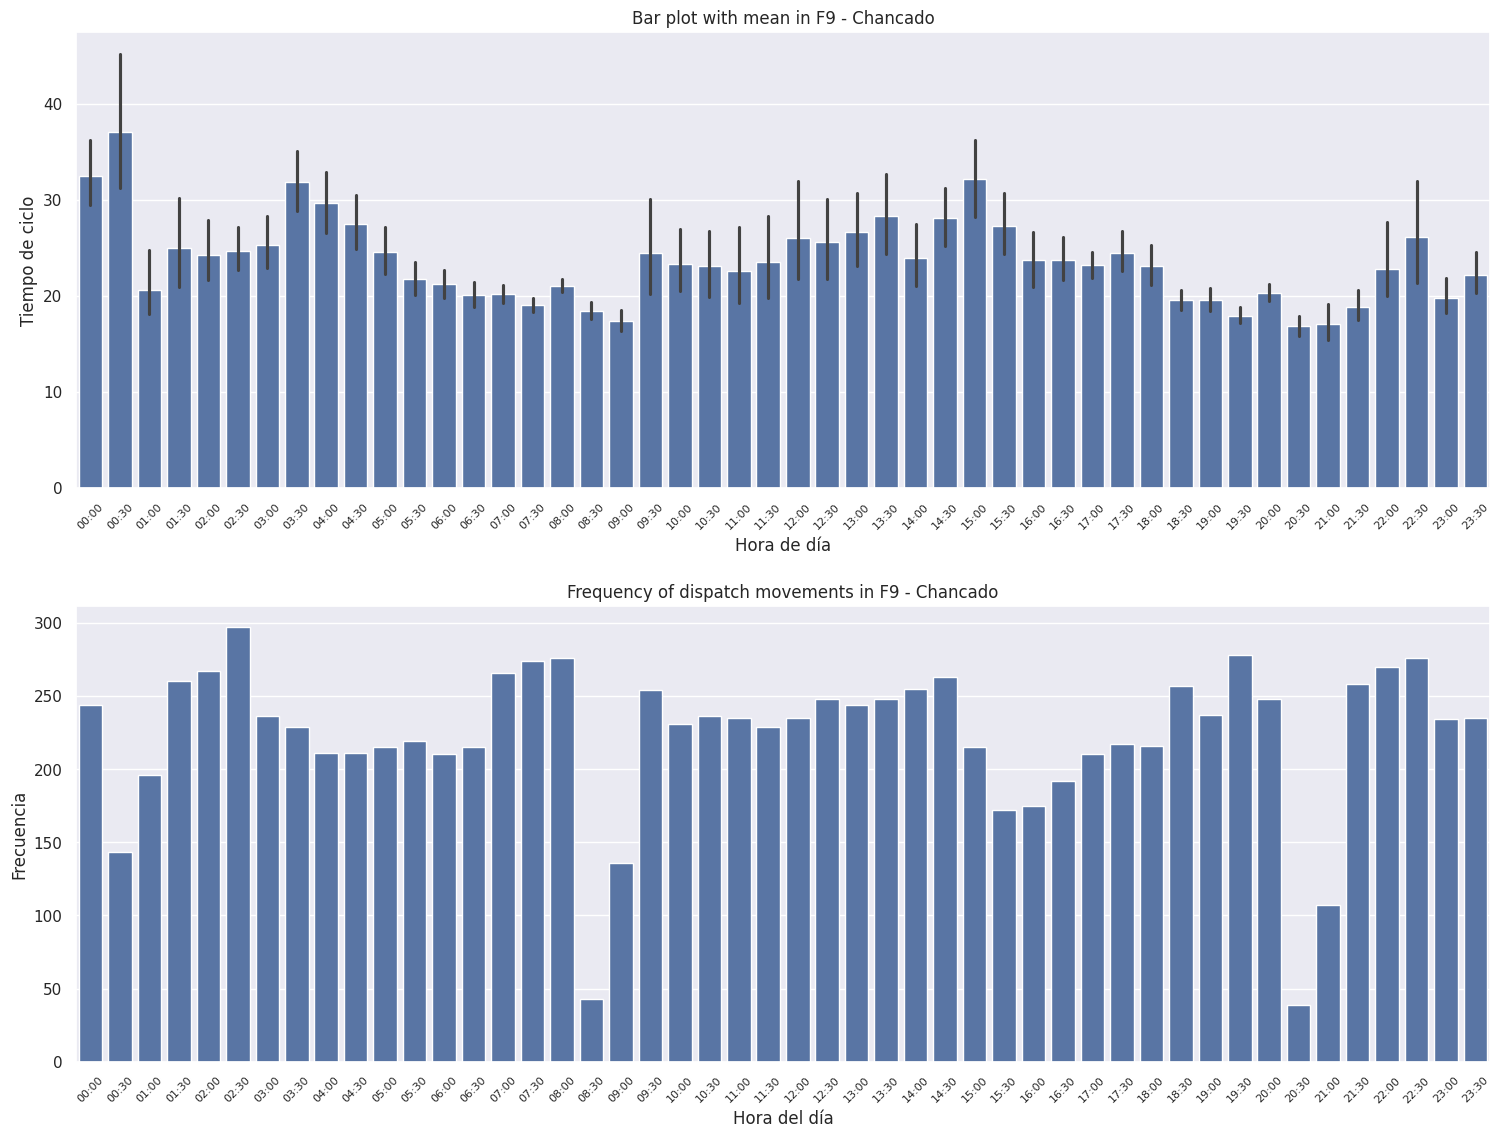

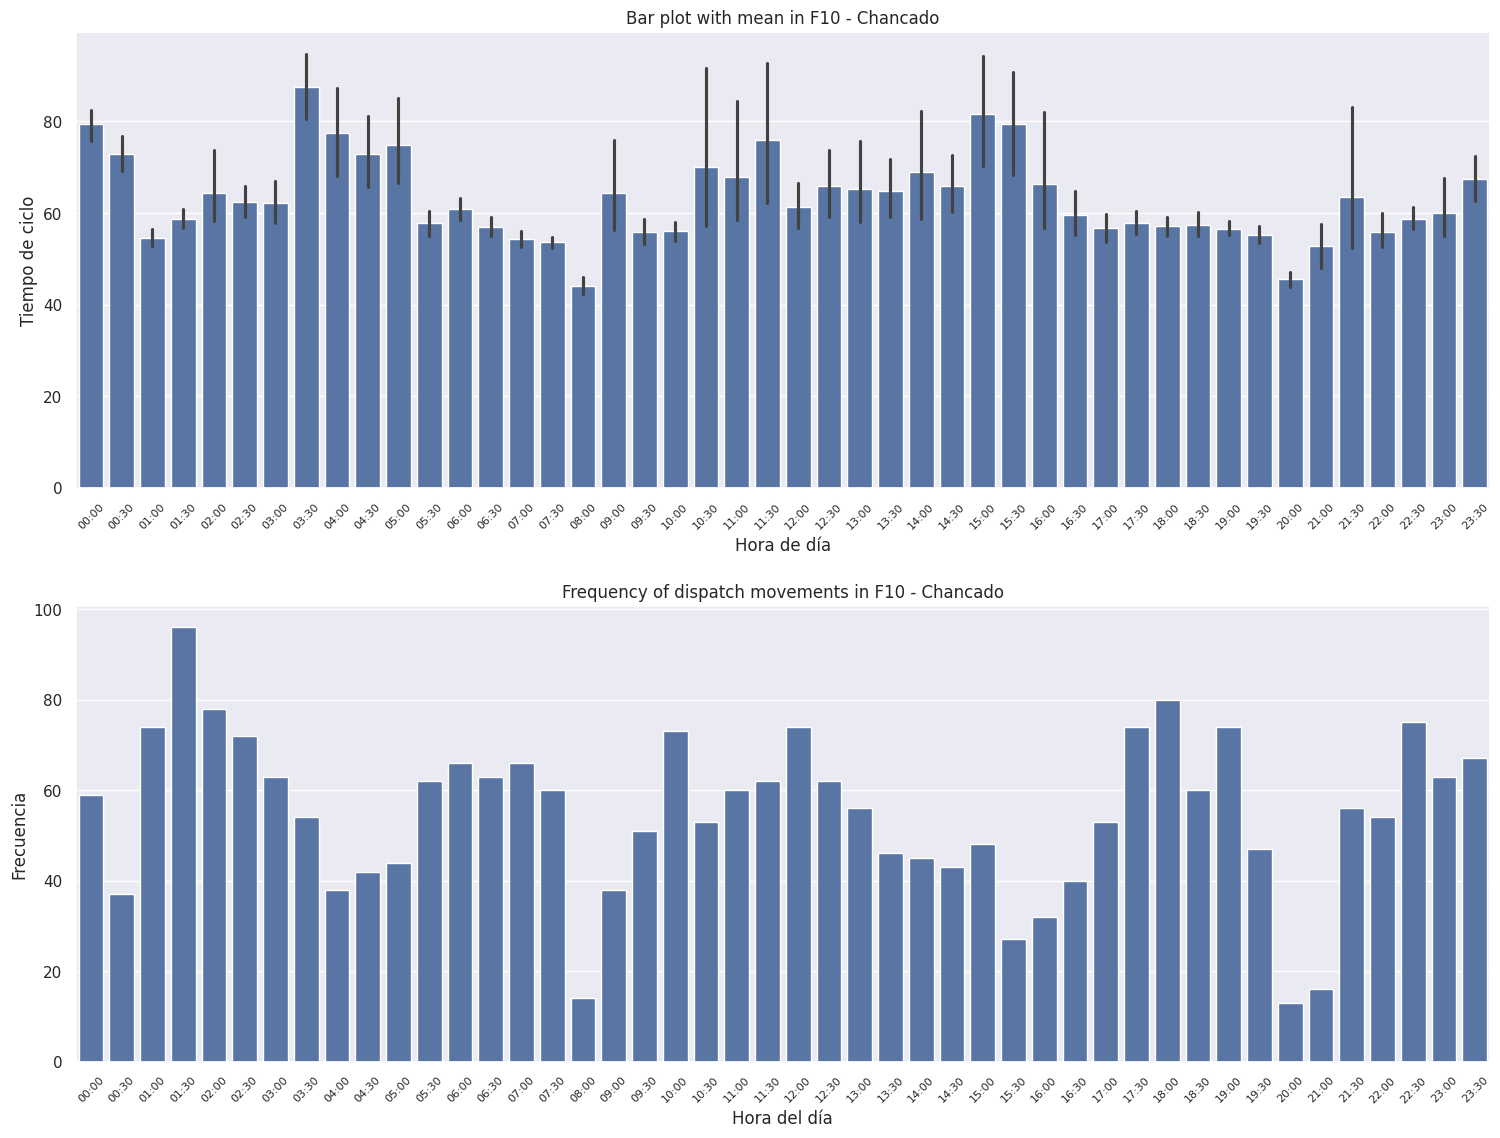

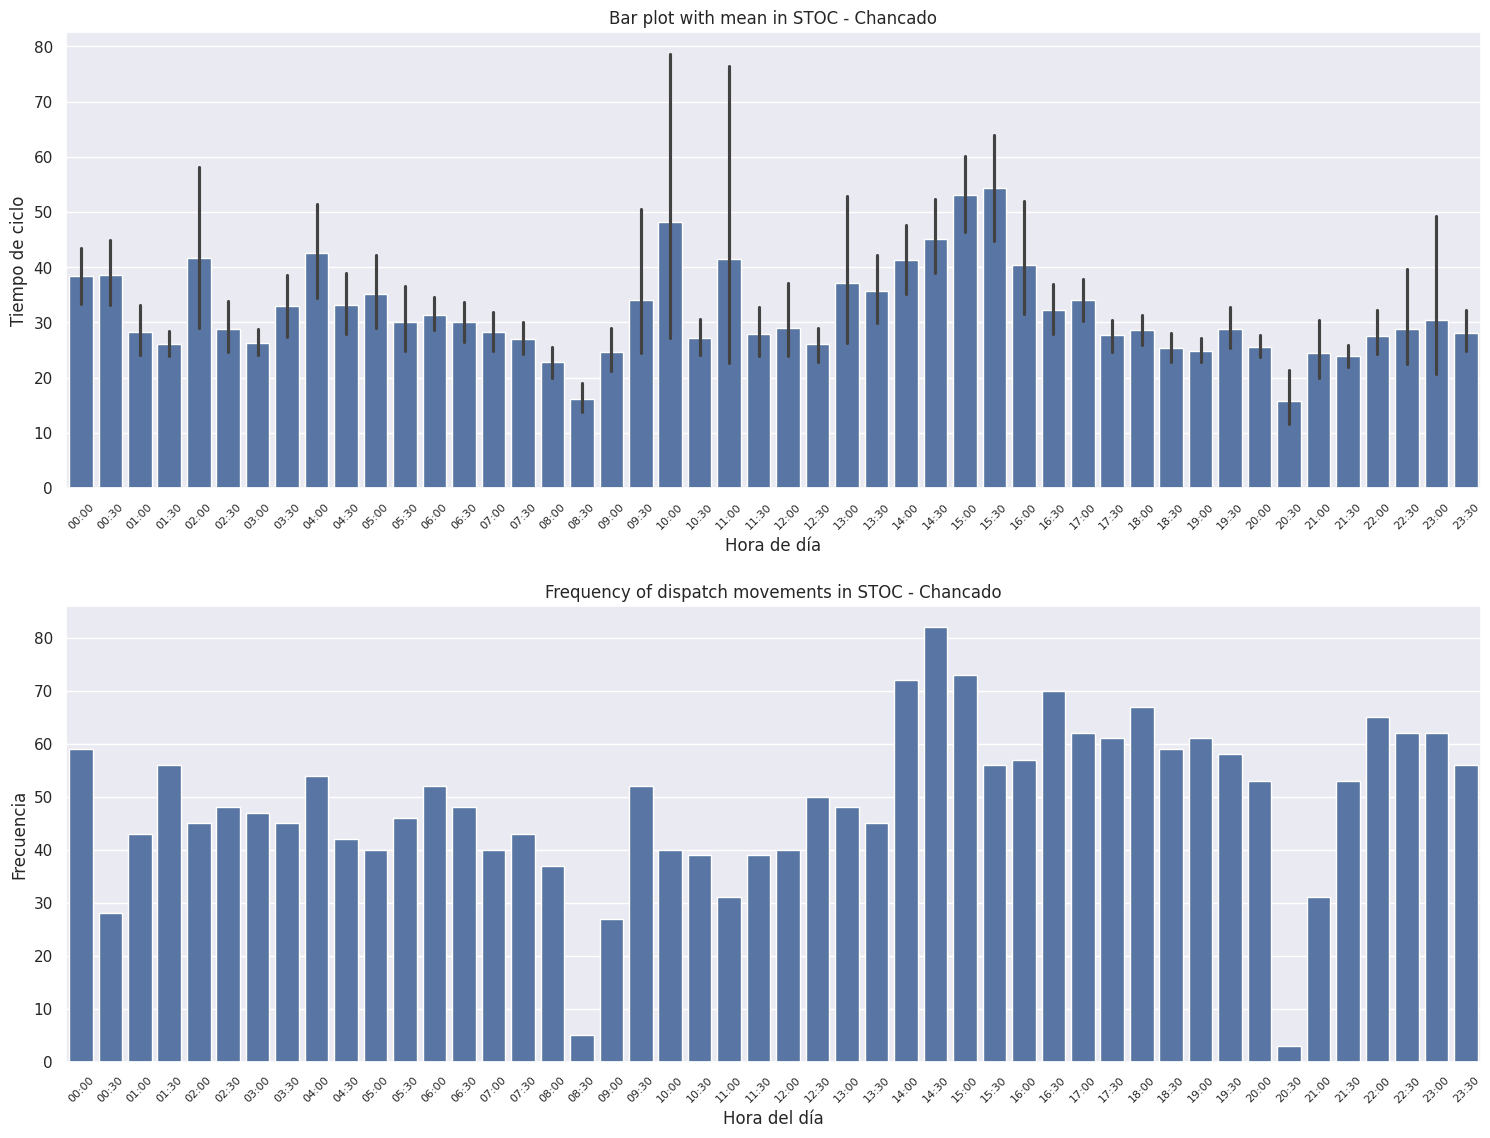

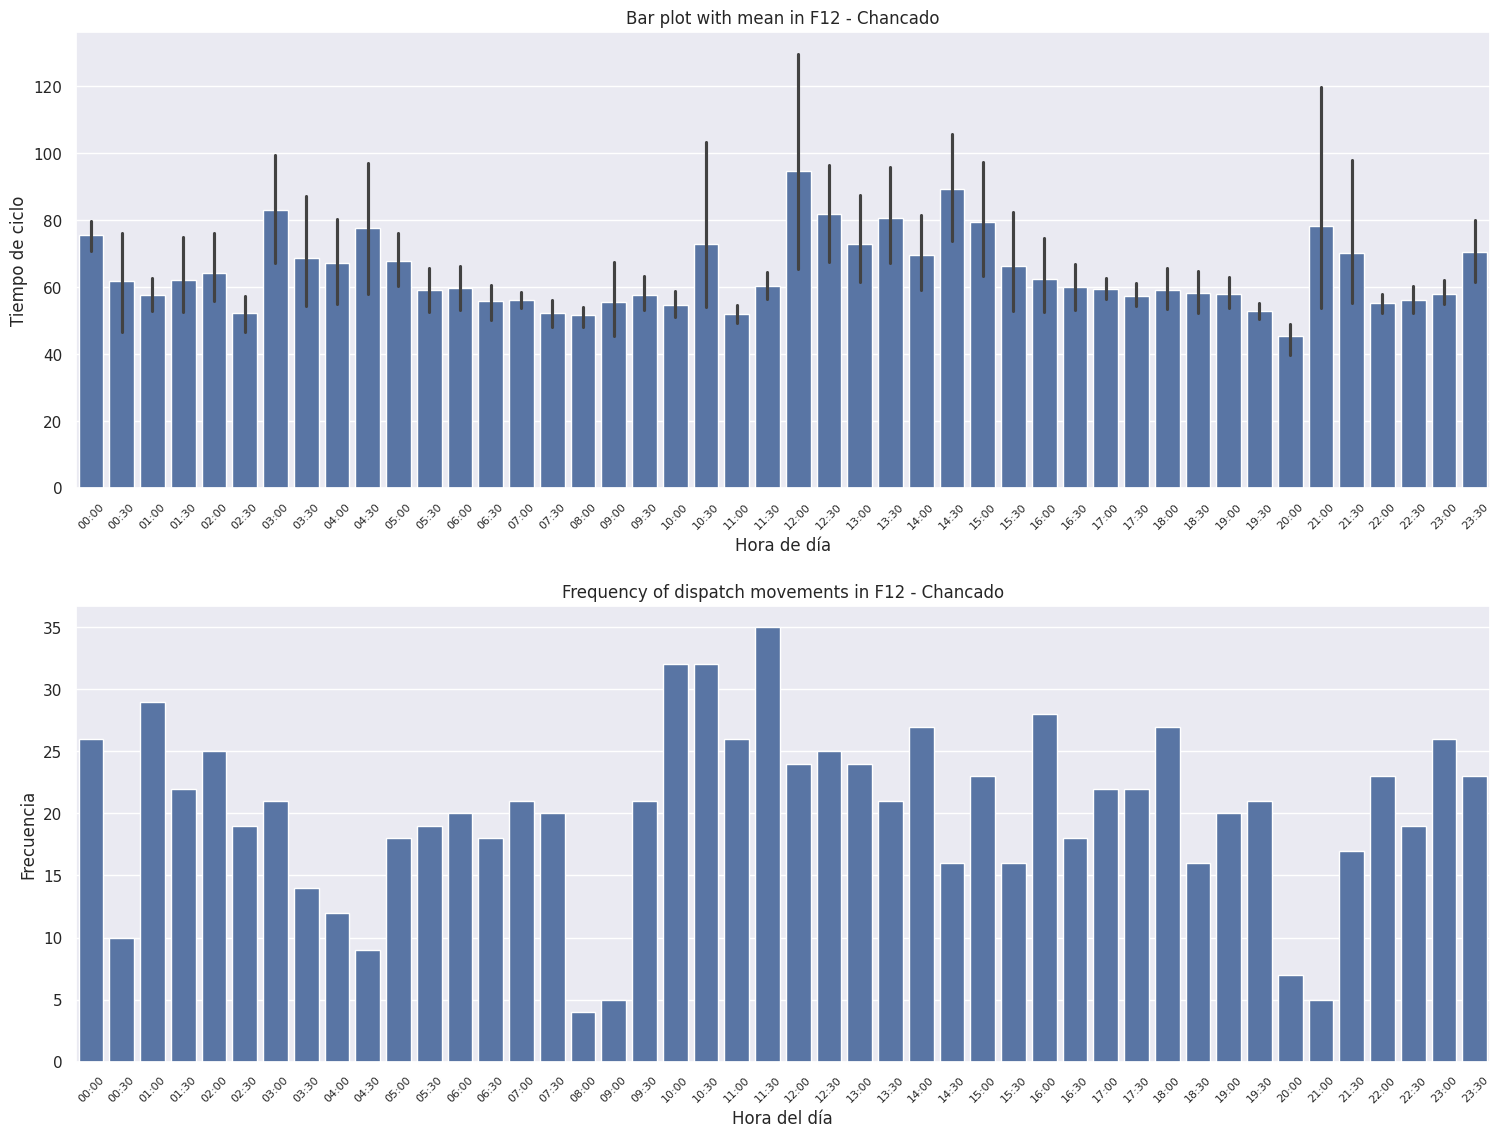

In [84]:
# list_origin_destinations: This variable contains all this variables
list_origin_destination_chancado = [place for place in list_origin_destinations if 'chancado' in place.lower()]
for origin_destination_item in list_origin_destination_chancado:
  plot_process_time(df_to_analyze, origin_destination_item, period='30T')